ITBA - Ingeniería Electrónica

25.87 - Redes Neuronales II - Computer Vision

---

**TP3 - TGS - Nov. 2024**

Grupo: 
* HEIR, Alejandro Nahuel - 62496
* SBRUZZI, Juan Francisco - 62517

---

Challenge: [TGS Salt Identification Challenge](https://www.kaggle.com/competitions/tgs-salt-identification-challenge)

Referencias: 
* Estructura principal: [U-net, dropout, augmentation, stratification](https://www.kaggle.com/code/phoenigs/u-net-dropout-augmentation-stratification)
* Custom metric: [Explanation of Scoring Metric](https://www.kaggle.com/code/pestipeti/explanation-of-scoring-metric)
* [Augmentation that works](https://www.kaggle.com/competitions/tgs-salt-identification-challenge/discussion/63974)
* [Improving from 0.78 to 0.84+](https://www.kaggle.com/competitions/tgs-salt-identification-challenge/discussion/65226)

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras import ops

import albumentations as A
!pip install -U albumentations --quiet

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

# EDA

In [3]:
train_df = pd.read_csv("/kaggle/input/tgs-salt-identification-challenge/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("/kaggle/input/tgs-salt-identification-challenge/depths.csv", index_col='id')

In [4]:
print(train_df.shape, depths_df.shape)

(4000, 0) (22000, 1)


In [5]:
train_df

Empty DataFrame
Columns: []
Index: [575d24d81d, a266a2a9df, 75efad62c1, 34e51dba6a, 4875705fb0, 782ae9b7e7, 9842f69f8d, aa94cfb806, 50d3073821, 28f865caaa, b5e1371b3b, 57e394bc67, b45ad3932e, ef51bbcde7, d4d34af4f7, 302ea1ac81, 40dcff68b3, 7845115d01, 3da729cae9, d67e3a11d8, b3396387a6, a5471f53d8, d27831fef2, 7faea04242, 9747413253, b9614348f4, 4696bb53e6, fc250f574c, 005b452274, 02117a400e, 4e4cadf03f, 1ee0d5b4d0, fdc28cafdc, 2bc8a3db3c, 35fd991255, 68a2df3195, 3be0c0be8e, 1f0b16aa13, 9bf982cf65, 36aa21019e, d422a9eb8f, e0b6a1211f, 5e3c2aa2bb, d3f3db7bd1, 0b176124c4, 368f635c4c, eabe9337a9, c4f2799234, 50290e75f9, 06289f69f8, 3f8634704b, f328eccbf3, 9f0ebbd210, dd5a90cf89, 5b836d2444, 6c3a9009c8, 1263576548, 5edb37f5a8, 3f8a8f4715, 75e041fbd8, 58777a8c79, b2899a1188, 428a877104, 13209940d7, d0319f0ec5, b92ff69b44, 9e9f3940a9, 728890d8f8, 754cfc4b80, 127ef4105f, 42758bb41a, 4e6855dbae, 4a12baccc4, 3281bb7282, f1774ff8e8, 628ea36ba6, 95a60e2f42, e2421eee13, fcb49356a5, 63feb8de2b, 992572448c, 0926b7396b, 8f407b64ae, e667f4d290, 7deaf30c4a, 28553d5d42, be565e046b, b183b2ddc4, cf11876547, 495a2d3c7c, a536f382ec, 8fb68e99e8, a8247ac73a, 9f3b8d0186, 05be75afd9, e4159ed1de, 3ed6d1c7df, 7977cbab6f, b221ece24b, 29d8bf3a4c, ...]

[4000 rows x 0 columns]

In [6]:
depths_df

z
id             
4ac19fb269  306
1825fadf99  157
f59821d067  305
5b435fad9d  503
e340e7bfca  783
...         ...
09f1675cfb  400
6947dbc4f4  804
68de95fb39  605
fdad2f99d8  309
d7c57f676e  532

[22000 rows x 1 columns]

In [7]:
depths_df['z']

id
4ac19fb269    306
1825fadf99    157
f59821d067    305
5b435fad9d    503
e340e7bfca    783
             ... 
09f1675cfb    400
6947dbc4f4    804
68de95fb39    605
fdad2f99d8    309
d7c57f676e    532
Name: z, Length: 22000, dtype: int64

In [8]:
train_df = train_df.join(depths_df) # agrega depths a cada id de train
train_df

z
id             
575d24d81d  843
a266a2a9df  794
75efad62c1  468
34e51dba6a  727
4875705fb0  797
...         ...
9cbd5ddba4  218
caa039b231  602
1306fcee4c  177
48d81e93d9  221
edf1e6ac00  460

[4000 rows x 1 columns]

In [9]:
test_df = depths_df[~depths_df.index.isin(train_df.index)] # test como los depths que no son train
test_df

z
id             
353e010b7b  264
5439dbbddf  557
71bab9f311  846
52551f7a80  610
512d8d9997  577
...         ...
09f1675cfb  400
6947dbc4f4  804
68de95fb39  605
fdad2f99d8  309
d7c57f676e  532

[18000 rows x 1 columns]

In [10]:
!unzip -o -q -u "/kaggle/input/tgs-salt-identification-challenge/train.zip" -d "/kaggle/working/train/"
!unzip -o -q -u "/kaggle/input/tgs-salt-identification-challenge/test.zip" -d "/kaggle/working/test/"

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [11]:
!tree -d

.
|-- test
|   `-- images
`-- train
    |-- images
    `-- masks

5 directories


In [12]:
!ls -1 /kaggle/working/test/images/ | wc -l
!ls -1 /kaggle/working/train/images/ | wc -l
!ls -1 /kaggle/working/train/masks/ | wc -l

18000
4000
4000


In [13]:
# se agregan las imágenes al train_df, normalizadas y BW
train_df['images'] = [np.array(load_img("/kaggle/working/train/images/{}.png".format(idx), color_mode='grayscale')) / 255 for idx in tqdm(train_df.index)]

100%|██████████| 4000/4000 [00:02<00:00, 1726.71it/s]


In [14]:
# se agregan las masks al train_df
train_df['masks'] = [np.array(load_img("/kaggle/working/train/masks/{}.png".format(idx), color_mode='grayscale')) for idx in tqdm(train_df.index)]
train_df['masks'] = train_df['masks'].apply(lambda x: (x > 0).astype(np.uint8))

100%|██████████| 4000/4000 [00:00<00:00, 6501.27it/s]


In [15]:
train_df.head(50)

z                                             images  \
id                                                                   
575d24d81d  843  [[0.5254901960784314, 0.5137254901960784, 0.52...   
a266a2a9df  794  [[0.3411764705882353, 0.3764705882352941, 0.33...   
75efad62c1  468  [[0.5686274509803921, 0.4666666666666667, 0.32...   
34e51dba6a  727  [[0.5411764705882353, 0.4745098039215686, 0.39...   
4875705fb0  797  [[0.06666666666666667, 0.0784313725490196, 0.0...   
782ae9b7e7  677  [[0.6078431372549019, 0.6196078431372549, 0.61...   
9842f69f8d  907  [[0.4392156862745098, 0.4117647058823529, 0.4,...   
aa94cfb806  754  [[0.5058823529411764, 0.49019607843137253, 0.4...   
50d3073821  810  [[0.4666666666666667, 0.5333333333333333, 0.41...   
28f865caaa  147  [[0.43137254901960786, 0.4392156862745098, 0.4...   
b5e1371b3b  325  [[0.4117647058823529, 0.4196078431372549, 0.43...   
57e394bc67  765  [[0.4, 0.396078431372549, 0.4, 0.4431372549019...   
b45ad3932e  613  [[0.43137254901960786, 0.4117647058823529, 0.4...   
ef51bbcde7  712  [[0.4, 0.396078431372549, 0.38823529411764707,...   
d4d34af4f7  114  [[0.3607843137254902, 0.3843137254901961, 0.42...   
302ea1ac81  470  [[0.18823529411764706, 0.1843137254901961, 0.1...   
40dcff68b3  707  [[0.44313725490196076, 0.4235294117647059, 0.3...   
7845115d01  343  [[0.4, 0.4117647058823529, 0.42745098039215684...   
3da729cae9  707  [[0.6823529411764706, 0.6745098039215687, 0.65...   
d67e3a11d8  585  [[0.5176470588235295, 0.5725490196078431, 0.50...   
b3396387a6  407  [[0.4117647058823529, 0.3803921568627451, 0.35...   
a5471f53d8  659  [[0.3803921568627451, 0.403921568627451, 0.407...   
d27831fef2  657  [[0.34901960784313724, 0.34901960784313724, 0....   
7faea04242  818  [[0.45098039215686275, 0.4549019607843137, 0.4...   
9747413253  472  [[0.5215686274509804, 0.4980392156862745, 0.51...   
b9614348f4  429  [[0.3686274509803922, 0.37254901960784315, 0.3...   
4696bb53e6  438  [[0.5019607843137255, 0.5176470588235295, 0.46...   
fc250f574c  684  [[0.9215686274509803, 0.9294117647058824, 0.93...   
005b452274  657  [[0.00392156862745098, 0.0, 0.0156862745098039...   
02117a400e  696  [[0.5411764705882353, 0.4745098039215686, 0.41...   
4e4cadf03f  703  [[0.5725490196078431, 0.5764705882352941, 0.54...   
1ee0d5b4d0  307  [[0.5294117647058824, 0.5607843137254902, 0.53...   
fdc28cafdc  338  [[0.34509803921568627, 0.3333333333333333, 0.3...   
2bc8a3db3c  353  [[0.3764705882352941, 0.403921568627451, 0.423...   
35fd991255  333  [[0.44313725490196076, 0.43137254901960786, 0....   
68a2df3195  555  [[0.42745098039215684, 0.4, 0.3725490196078431...   
3be0c0be8e  797  [[0.40784313725490196, 0.45098039215686275, 0....   
1f0b16aa13  364  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
9bf982cf65  716  [[0.596078431372549, 0.6039215686274509, 0.607...   
36aa21019e  482  [[0.2549019607843137, 0.2549019607843137, 0.27...   
d422a9eb8f  662  [[0.403921568627451, 0.4196078431372549, 0.435...   
e0b6a1211f  193  [[0.24705882352941178, 0.24705882352941178, 0....   
5e3c2aa2bb  307  [[0.3333333333333333, 0.3333333333333333, 0.33...   
d3f3db7bd1  258  [[0.34509803921568627, 0.34509803921568627, 0....   
0b176124c4  744  [[0.5882352941176471, 0.5607843137254902, 0.55...   
368f635c4c  698  [[0.34901960784313724, 0.4627450980392157, 0.4...   
eabe9337a9  540  [[0.4666666666666667, 0.4549019607843137, 0.44...   
c4f2799234  188  [[0.47058823529411764, 0.4823529411764706, 0.4...   
50290e75f9  658  [[0.38823529411764707, 0.3803921568627451, 0.3...   
06289f69f8  644  [[0.5450980392156862, 0.5490196078431373, 0.55...   

                                                        masks  
id                                                             
575d24d81d  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
a266a2a9df  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
75efad62c1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
34e51dba6a  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Las masks son las anotaciones de cada pixel de las imagenes:
* 1: sal
* 0: sedimento

Para id=5b8dc086ff, z=593


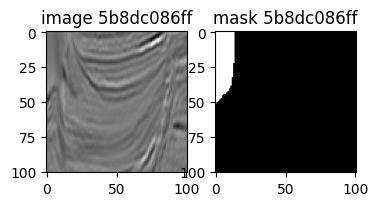


Para id=86bc03a8a6, z=845


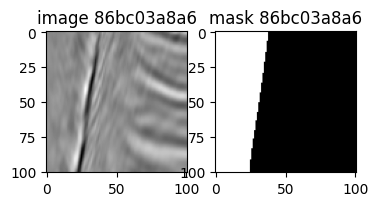


Para id=7187f4c02c, z=207


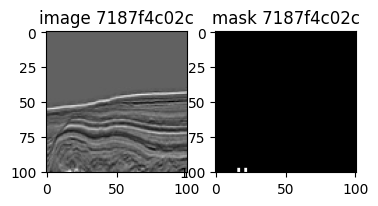


Para id=ca78405cea, z=403


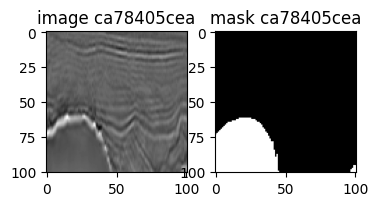


Para id=875dda3975, z=727


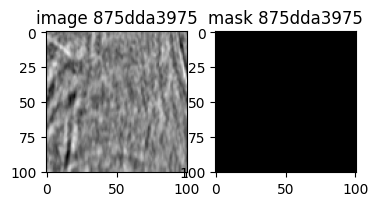


Para id=a531b78648, z=775


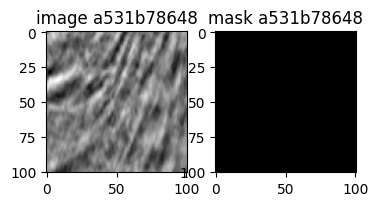

In [16]:
for i in range(1, 7):
    refid = train_df.sample(1).index[0] # id random del train_df
    print(f"Para id={refid}, z={train_df['z'][refid]}")

    fig, ax = plt.subplots(1, 2, figsize=(4, 4))

    ax[0].imshow(train_df['images'][refid], cmap='gray')
    ax[0].set_title(f"image {refid}")

    ax[1].imshow(train_df['masks'][refid], cmap='gray')
    ax[1].set_title(f"mask {refid}")
    plt.show()
    print()

In [17]:
img_size_ori = 101 # 101x101
img_size_target = 128 # 128x128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

## Salt coverage classification

In [18]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df.coverage = train_df.coverage / np.max(train_df.coverage) 

min_cov = np.floor(np.min(train_df.coverage)).astype(np.float64)
max_cov = np.ceil(np.max(train_df.coverage)).astype(np.float64)

min_cov, max_cov

(0.0, 1.0)

In [19]:
def cov_to_class(val, num_classes=11):    
#     if val < min_cov or val > max_cov:
#         raise ValueError(f"Coverage value ({val}) is outside the expected range ({min_cov} - {max_cov})")

#     normalized_cov = (val - min_cov) / (max_cov - min_cov)

#     class_index = int(np.floor(normalized_cov * num_classes))
#     return class_index
    for i in range(0, num_classes):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

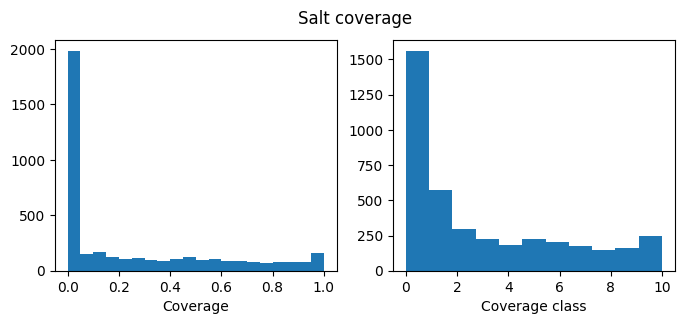

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))
plt.suptitle("Salt coverage")
axs[0].hist(train_df.coverage, bins=20)
axs[0].set_xlabel("Coverage")
axs[1].hist(train_df.coverage_class, bins=11)
axs[1].set_xlabel("Coverage class")

Text(0, 0.5, 'Coverage class')

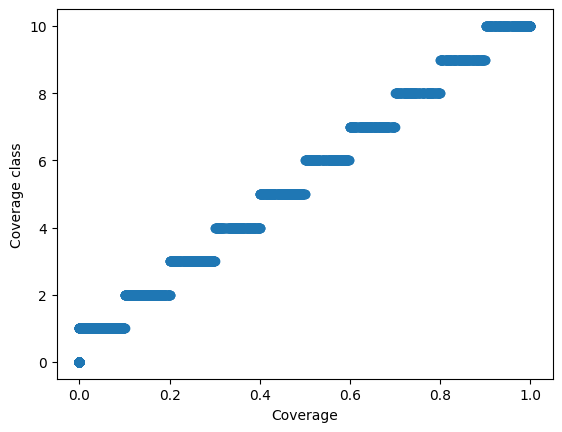

In [21]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

## Depth distributions

Text(0.5, 1.0, 'Depth distribution')

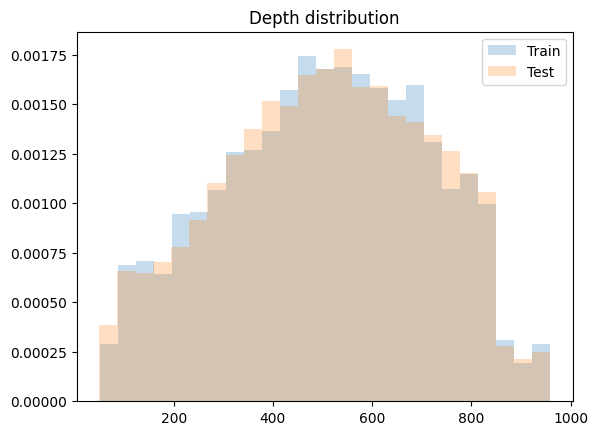

In [22]:
plt.hist(train_df.z, label="Train", alpha=0.25, density=True, bins=25)
plt.hist(test_df.z, label="Test", alpha=0.25, density=True, bins=25)
plt.legend()
plt.title("Depth distribution")

## Some example images

Text(0.5, 0.98, 'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

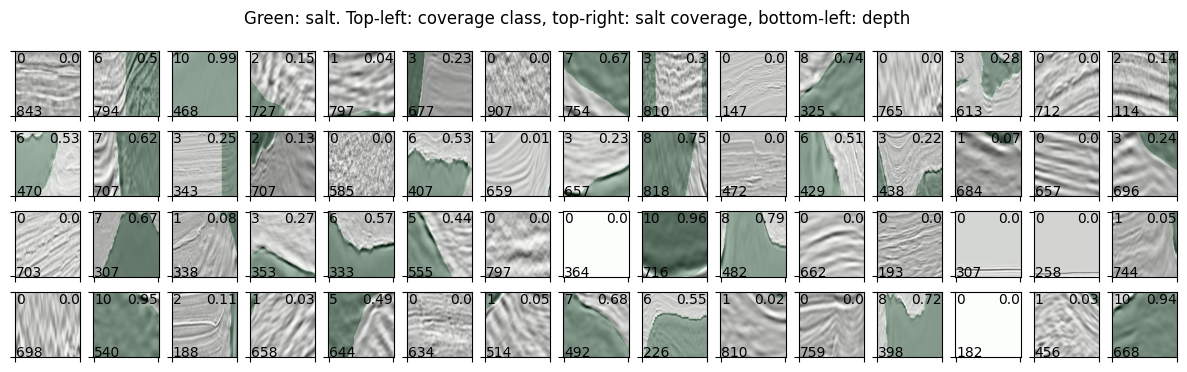

In [23]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Train/validation split w/ stratification by salt coverage

In [24]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5, 1.0, 'Scaled image')

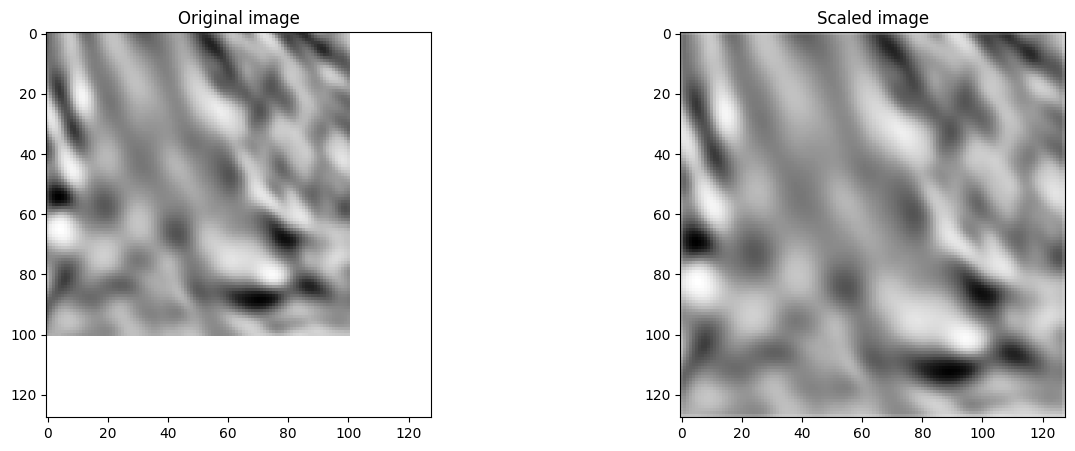

In [25]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

# Data augmentation

> En la implementación de referencia, solo hacen mirror horizontal

In [26]:
augmentations  = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.33),
    A.OneOf([
        A.Sequential([
            A.ElasticTransform(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        ], p=1.0),
        A.Sequential([
            A.RandomCrop(width=img_size_target*0.5, height=img_size_target*0.5, p=1.0),
            A.Resize(128, 128, p=1.0)
        ], p=1.0),      
        A.Sequential([
            A.RandomCrop(width=img_size_target*0.75, height=img_size_target*0.75, p=1.0),
            A.Resize(128, 128, p=1.0)
        ], p=1.0),      
      ], p=1.0)
  ])

In [27]:
def aug_x_y(x, y, augs):
    augmented = augs(image=x, mask=y)
    return augmented['image'], augmented['mask']

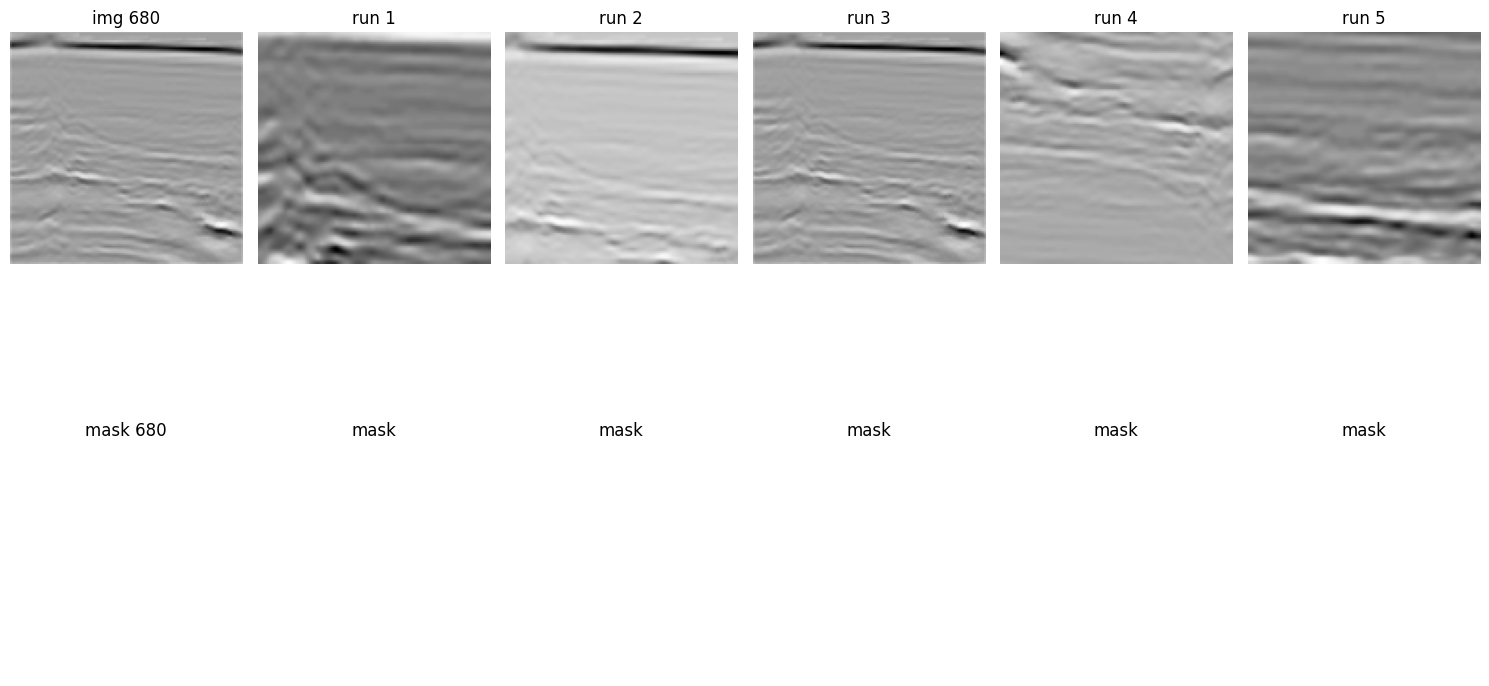

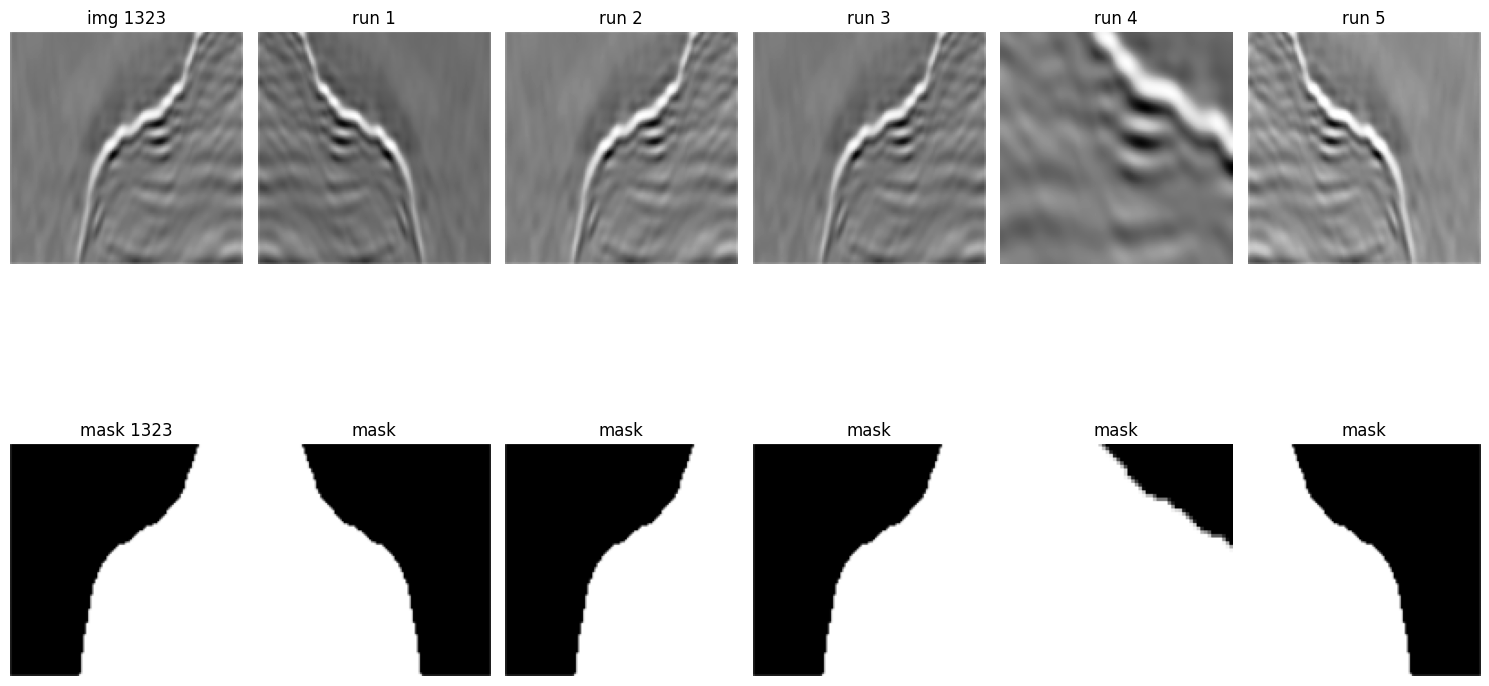

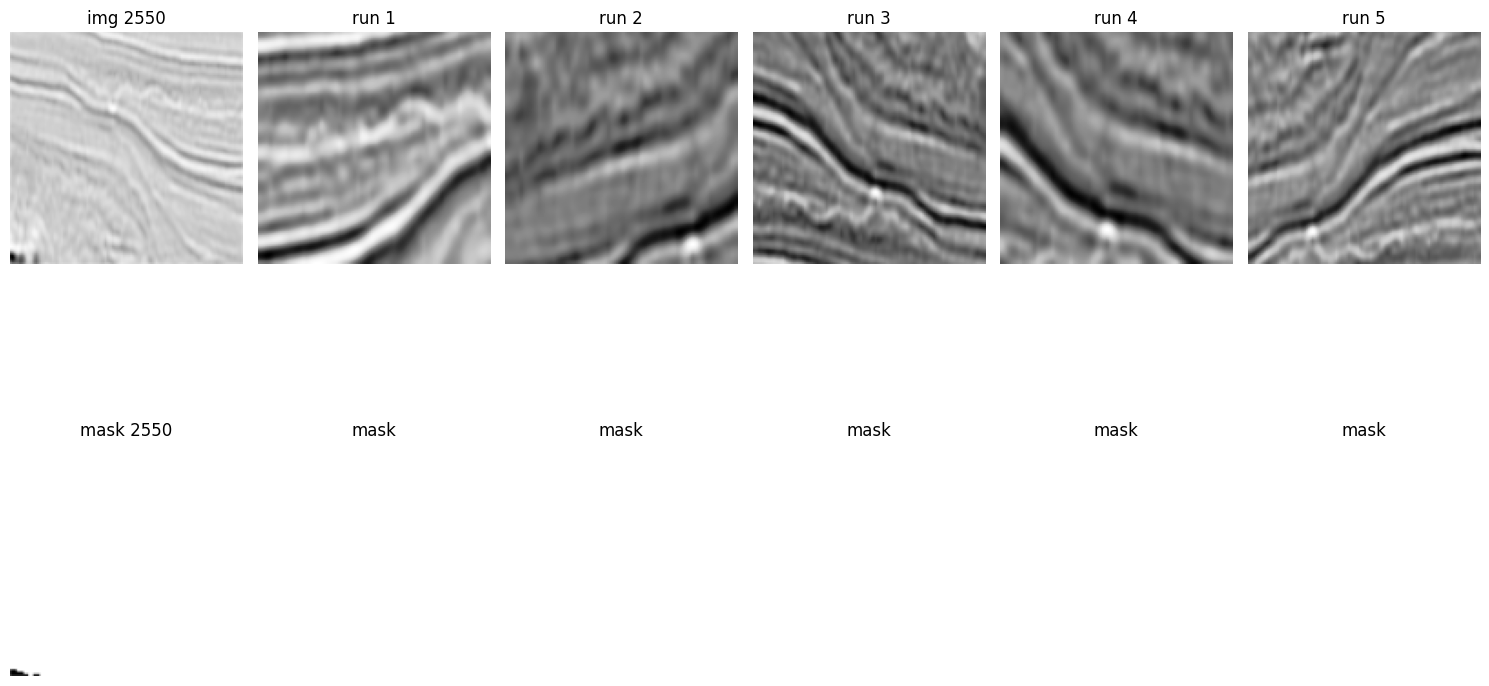

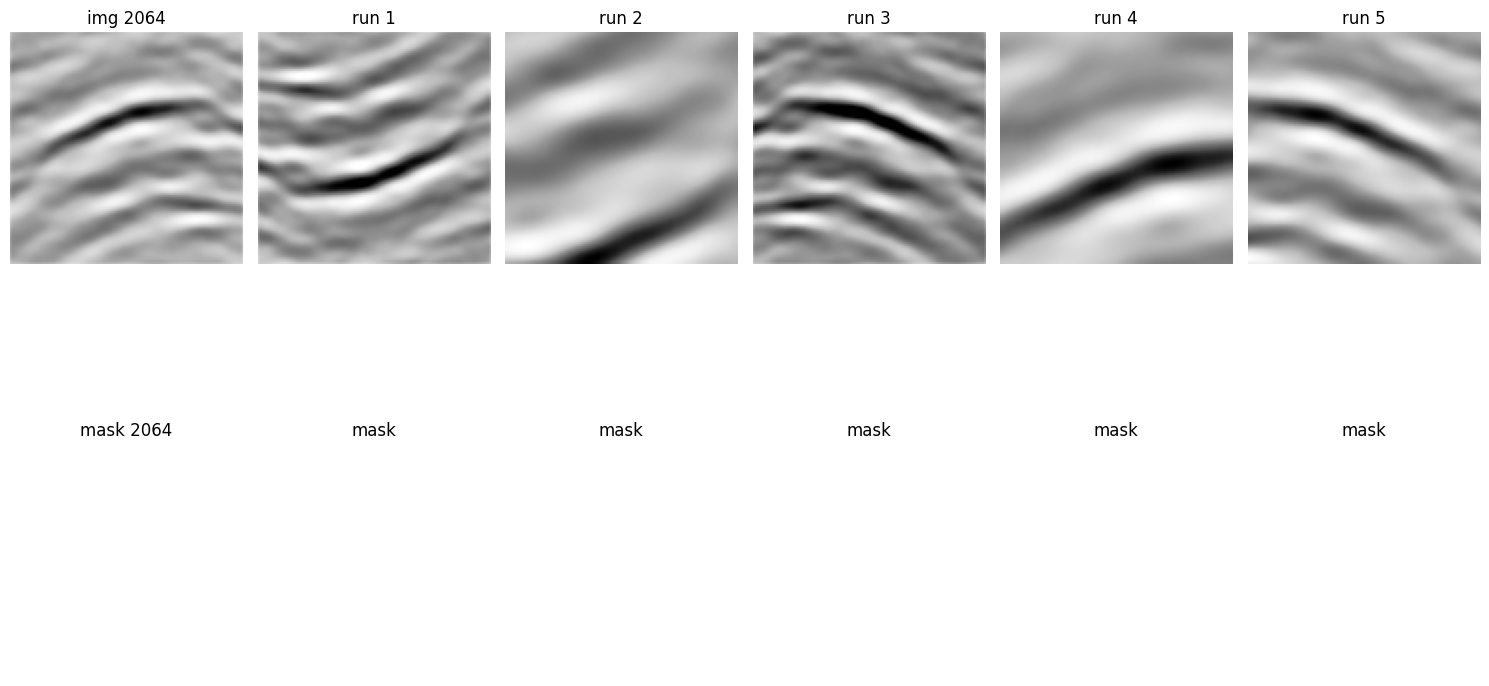

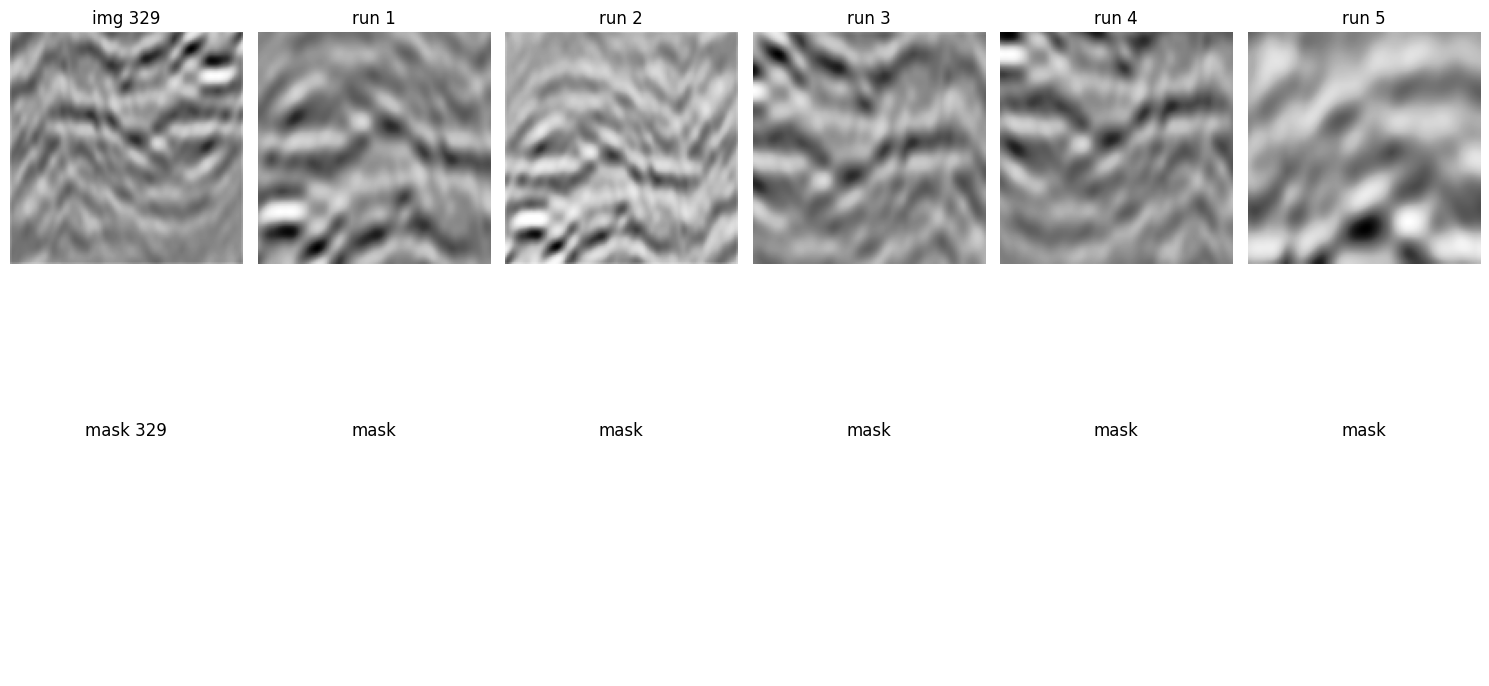

In [28]:
for u in range(0, 5):
    random_index = np.random.randint(0, len(x_train))
    x_original, y_original = x_train[random_index], y_train[random_index]
    
    fig, axes = plt.subplots(2, 6, figsize=(15, 10))
    
    axes[0, 0].imshow(x_original.squeeze(), cmap="Greys")
    axes[0, 0].axis('off')
    axes[0, 0].set_title(f"img {random_index}")
    
    axes[1, 0].imshow(y_original.squeeze(), cmap="Greys")
    axes[1, 0].axis('off')
    axes[1, 0].set_title(f"mask {random_index}")
    
    for i in range(1, 6):
        x_aug, y_aug = aug_x_y(x_original, y_original, augmentations)
    
        axes[0, i].imshow(x_aug.squeeze(), cmap="Greys")
        axes[0, i].axis('off')
        axes[0, i].set_title(f"run {i}")
    
        axes[1, i].imshow(y_aug.squeeze(), cmap="Greys")
        axes[1, i].axis('off')
        axes[1, i].set_title(f"mask")
    
    plt.tight_layout()
    plt.show() 

In [29]:
augmentations_runs = 3
base_len = len(x_train)

for i in tqdm(range(augmentations_runs)):
    tmp_x_aug = []
    tmp_y_aug = []
    
    for j in tqdm(range(base_len)):
        x_aug, y_aug = aug_x_y(x_train[j], y_train[j], augmentations)
        tmp_x_aug.append(x_aug)
        tmp_y_aug.append(y_aug)

    tmp_x_aug = np.array(tmp_x_aug)
    tmp_y_aug = np.array(tmp_y_aug)

    x_train = np.concatenate((x_train, tmp_x_aug), axis=0)
    y_train = np.concatenate((y_train, tmp_y_aug), axis=0)

100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


In [30]:
base_len, len(x_train)

(3200, 12800)

Text(0.5, 0.98, 'Top row: original images, bottom row: augmented images')

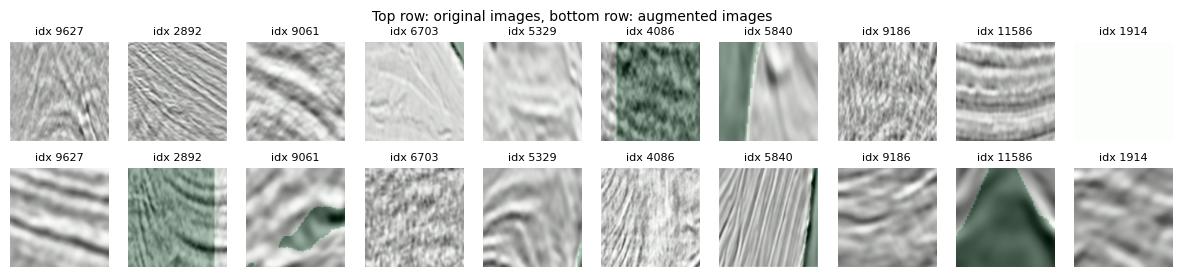

In [31]:
random_indices = np.random.choice(len(x_train), size=10, replace=False)

fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i,idx in enumerate(random_indices):
    axs[0][i].imshow(x_train[idx].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[idx].squeeze(), cmap="Greens", alpha=0.3)
    axs[0][i].set_title(f"idx {idx}", fontsize=8)
    axs[0][i].axis('off')
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].set_title(f"idx {idx}", fontsize=8)
    axs[1][i].axis('off')
fig.suptitle("Top row: original images, bottom row: augmented images", fontsize=10)

# Model, U-Net

## Build

In [92]:
# def build_model(input_layer, start_neurons):
#     # 128 -> 64
#     conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
#     conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
#     pool1 = MaxPooling2D((2, 2))(conv1)
#     pool1 = Dropout(0.25)(pool1)

#     # 64 -> 32
#     conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
#     conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
#     pool2 = MaxPooling2D((2, 2))(conv2)
#     pool2 = Dropout(0.5)(pool2)

#     # 32 -> 16
#     conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
#     conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
#     pool3 = MaxPooling2D((2, 2))(conv3)
#     pool3 = Dropout(0.5)(pool3)

#     # 16 -> 8
#     conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
#     conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
#     pool4 = MaxPooling2D((2, 2))(conv4)
#     pool4 = Dropout(0.5)(pool4)

#     # Middle
#     convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
#     convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

#     # 8 -> 16
#     deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
#     uconv4 = concatenate([deconv4, conv4])
#     uconv4 = Dropout(0.5)(uconv4)
#     uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
#     uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

#     # 16 -> 32
#     deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
#     uconv3 = concatenate([deconv3, conv3])
#     uconv3 = Dropout(0.5)(uconv3)
#     uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
#     uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

#     # 32 -> 64
#     deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
#     uconv2 = concatenate([deconv2, conv2])
#     uconv2 = Dropout(0.5)(uconv2)
#     uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
#     uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

#     # 64 -> 128
#     deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
#     uconv1 = concatenate([deconv1, conv1])
#     uconv1 = Dropout(0.5)(uconv1)
#     uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
#     uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

#     uconv1 = Dropout(0.5)(uconv1)
#     output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
#     return output_layer

# input_layer = Input((img_size_target, img_size_target, 1))
# output_layer = build_model(input_layer, 16)

def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(negative_slope=0.1)(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = LeakyReLU(negative_slope=0.1)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(negative_slope=0.1)(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(negative_slope=0.1)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(negative_slope=0.1)(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(negative_slope=0.1)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), padding="same")(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(negative_slope=0.1)(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), padding="same")(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(negative_slope=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), padding="same")(pool4)
    convm = BatchNormalization()(convm)
    convm = LeakyReLU(negative_slope=0.1)(convm)
    convm = Conv2D(start_neurons * 16, (3, 3), padding="same")(convm)
    convm = BatchNormalization()(convm)
    convm = LeakyReLU(negative_slope=0.1)(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = LeakyReLU(negative_slope=0.1)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = LeakyReLU(negative_slope=0.1)(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = LeakyReLU(negative_slope=0.1)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = LeakyReLU(negative_slope=0.1)(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = LeakyReLU(negative_slope=0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = LeakyReLU(negative_slope=0.1)(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = LeakyReLU(negative_slope=0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = LeakyReLU(negative_slope=0.1)(uconv1)

    uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)
model = Model(input_layer, output_layer)

## IoU custom metric

https://keras.io/api/metrics/#creating-custom-metrics

In [117]:
def custom_iou(y_true, y_pred):
    y_pred = ops.cast(y_pred > 0.5, tf.bool)
    y_true = ops.cast(y_true > 0.5, tf.bool)

    intersection = ops.sum(ops.cast(ops.logical_and(y_true, y_pred), tf.float32))
    union = ops.sum(ops.cast(ops.logical_or(y_true, y_pred), tf.float32))

    iou = intersection / ops.maximum(union, tf.keras.backend.epsilon())

    thresholds = tf.range(0.1, 1.0, 0.05)
    s = tf.map_fn(lambda t: ops.cast(iou > t, tf.float32), thresholds)

    return ops.mean(s)

## Compile

In [118]:
model = Model(input_layer, output_layer)

# model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])

model.compile(loss="binary_crossentropy",
              optimizer='adam', 
              metrics=[custom_iou]
             )

model.summary()

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_72      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 128,  │      2,320 │ leaky_re_lu_72[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_73      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ leaky_re_lu_73[0… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 64, 64,    │          0 │ max_pooling2d_16… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 64, 64,    │      4,640 │ dropout_36[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_74      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │      9,248 │ leaky_re_lu_74[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_75      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 32,    │          0 │ leaky_re_lu_75[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 32, 32,    │          0 │ max_pooling2d_17

 Total params: 2,164,305 (8.26 MB)

 Trainable params: 2,161,361 (8.24 MB)

 Non-trainable params: 2,944 (11.50 KB)

# Training

In [103]:
early_stopping = EarlyStopping(monitor='val_custom_iou', 
                               patience=10, 
                               verbose=1, 
                               restore_best_weights=True,
                               mode='max')

model_checkpoint = ModelCheckpoint("/kaggle/working/bestmodel.keras", 
                                   monitor='val_custom_iou',
                                   save_best_only=True, 
                                   verbose=1,
                                   mode='max')

reduce_lr = ReduceLROnPlateau(factor=0.1, 
                              mode='max',
                              monitor='val_custom_iou',
                              patience=5, 
                              min_lr=1e-6, 
                              verbose=1)

epochs = 100
batch_size = 64

In [119]:
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - custom_iou: 0.2338 - loss: 0.6375
Epoch 1: val_custom_iou improved from -inf to 0.21368, saving model to /kaggle/working/bestmodel.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 63s 177ms/step - custom_iou: 0.2343 - loss: 0.6369 - val_custom_iou: 0.2137 - val_loss: 3.4601 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - custom_iou: 0.4608 - loss: 0.3950
Epoch 2: val_custom_iou improved from 0.21368 to 0.40171, saving model to /kaggle/working/bestmodel.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - custom_iou: 0.4608 - loss: 0.3949 - val_custom_iou: 0.4017 - val_loss: 0.7378 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - custom_iou: 0.5011 - loss: 0.3651
Epoch 3: val_custom_iou improved from 0.40171 to 0.47436, saving model to /kaggle/working/bestmodel.keras
200/200 ━━━━━━━━━━━━━━━━━━━━ 32s 161ms/step - custom_iou: 0.5011 - loss: 0.3651 - val_custom_iou: 0.4744 - val_loss:

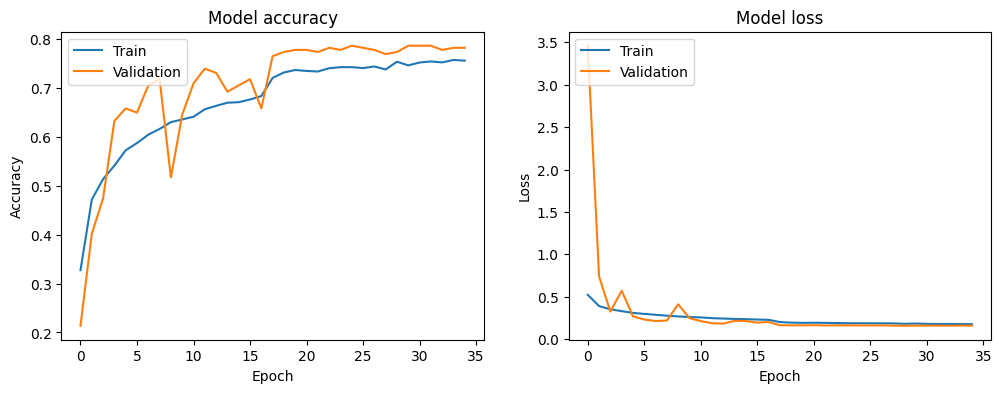

In [122]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['custom_iou'])
plt.plot(history.history['val_custom_iou'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# model = load_model("/kaggle/working/bestmodel.keras")

# Raw predict over val

In [123]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


Text(0.5, 0.98, 'Top row: original images with masks, Bottom row: predicted masks. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

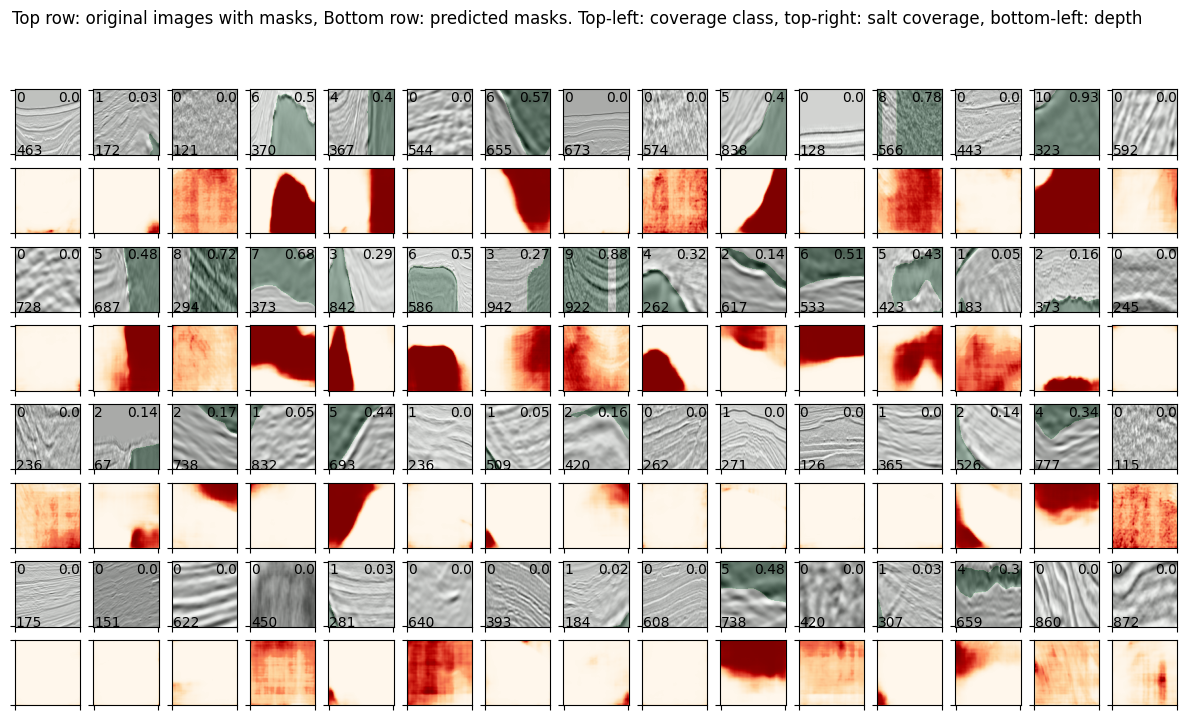

In [124]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height * 2, grid_width, figsize=(grid_width, grid_height * 2))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    
    ax_img = axs[int(i / grid_width) * 2, i % grid_width]
    ax_pred = axs[int(i / grid_width) * 2 + 1, i % grid_width]
    
    ax_img.imshow(img, cmap="Greys")
    ax_img.imshow(mask, alpha=0.3, cmap="Greens")
    ax_img.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax_img.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax_img.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax_img.set_yticklabels([])
    ax_img.set_xticklabels([])
    
    ax_pred.imshow(pred, cmap="OrRd")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

plt.suptitle("Top row: original images with masks, Bottom row: predicted masks. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Raw predict over test

In [125]:
x_test = np.array([upsample(np.array(load_img("/kaggle/working/test/images/{}.png".format(idx), color_mode='grayscale'))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

100%|██████████| 18000/18000 [00:26<00:00, 674.88it/s]


In [126]:
x_test_subset = x_test[0:32]

preds_test_subset = model.predict(x_test_subset).reshape(-1, img_size_target, img_size_target)
preds_test_subset = np.array([downsample(x) for x in preds_test_subset])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


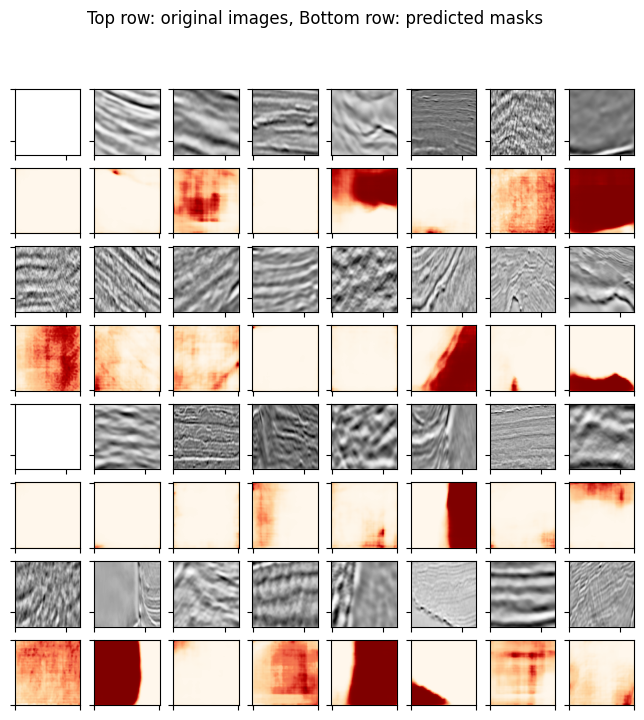

In [127]:
grid_width = 8
grid_height = int(np.ceil(len(x_test_subset) / grid_width))

fig, axs = plt.subplots(grid_height * 2, grid_width, figsize=(grid_width, grid_height * 2))

for i in range(len(x_test_subset)):
    img = x_test_subset[i].reshape(img_size_target, img_size_target)
    pred = preds_test_subset[i]
    
    ax_img = axs[int(i / grid_width) * 2, i % grid_width]
    ax_pred = axs[int(i / grid_width) * 2 + 1, i % grid_width]
    
    ax_img.imshow(img, cmap="Greys")
    ax_img.set_yticklabels([])
    ax_img.set_xticklabels([])
    
    ax_pred.imshow(pred, cmap="OrRd")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

plt.suptitle("Top row: original images, Bottom row: predicted masks")
plt.show()

# Scoring

In [128]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [129]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm(thresholds)])

100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


In [131]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

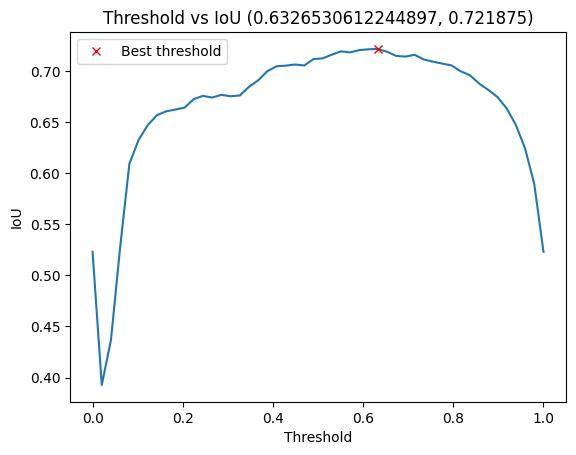

In [132]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Submission

In [133]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [134]:
preds_test = model.predict(x_test)

563/563 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step


In [135]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm(test_df.index.values))}

100%|██████████| 18000/18000 [05:41<00:00, 52.68it/s]


In [136]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')